In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time,string
import os,json,re,string
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
token = {"username":"vinaybhupalam","key":"5c27e8b73e30502d96da3d5b41a37fed"}
if not os.path.exists('/root/.kaggle'):
  os.mkdir('/root/.kaggle')
  with open('/root/.kaggle/kaggle.json', 'w+') as file:
      json.dump(token, file)

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 96% 233M/242M [00:03<00:00, 78.4MB/s]
100% 242M/242M [00:03<00:00, 66.4MB/s]


In [0]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [0]:
def clean_text_data(text):
  tokens = text.split() 
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  #Remove <br> and <a> strings in the text

  tokens = [re.sub("<a>|</a>|<br>|<br />" ,"",w) for w in tokens]
 
  # remove remaining tokens that are not alphabetic and convert to lower case
  tokens = [word.lower() for word in tokens if word.isalpha()]
  #Adding start and end tags to the text.
  tokens.append("<end>")
  tokens.insert(0 ,"<start>")
 
  return tokens 

In [0]:
def create_dataset(path, num_examples):
  data=pd.read_csv(path)
  reviews =[]
  summaries =[]
  for i in range(num_examples):
  #lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    try:
      review = data['Text'][i]
      summary = data['Summary'][i]  
                                
      if review is not None and summary is not None:  
          # print("Review :" +review)
          # print("summary :" +summary)       
          reviews.append(clean_text_data(review))
          summaries.append(clean_text_data(summary))
    except Exception as Error:
     print(Error)         
  return reviews,summaries          


In [0]:
reviews,summaries = create_dataset("Reviews.csv" ,4000)
print(len(reviews))
# data = pd.read_csv("Reviews.csv")
# data.head()

4000


In [0]:
def tokenize(lang,padding_length):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen=padding_length,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def get_data_distribution(text_data):
  text_length_list = [len(text) for text in text_data]
  return text_length_list,max(text_length_list)

In [0]:
def get_embedding_matrix(tokenizer,model,embedding_size = 300):
  vocabulary_size = len(tokenizer.word_index) + 1

  # create an empty embedding matix
  embedding_weights = np.zeros((vocabulary_size, embedding_size))

  # create a word to index dictionary mapping
  word2id = tokenizer.word_index
  
  # copy vectors from word2vec model to the words present in corpus
  for word, index in word2id.items():
      try:
          embedding_weights[index, :] = model[word]
      except KeyError:
          #print("Word not found {}" .format(word))
          pass
  return vocabulary_size,embedding_weights,word2id

In [0]:
review_length_distribution ,max_length_review = get_data_distribution(reviews)
summary_length_distribution,max_length_summary = get_data_distribution(summaries)

print(max_length_review,max_length_summary)
print(len(review_length_distribution))

921 29
4000


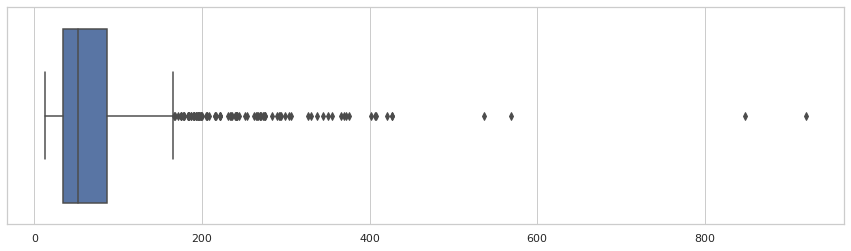

In [0]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
ax = sns.boxplot(x=review_length_distribution ,ax=ax)

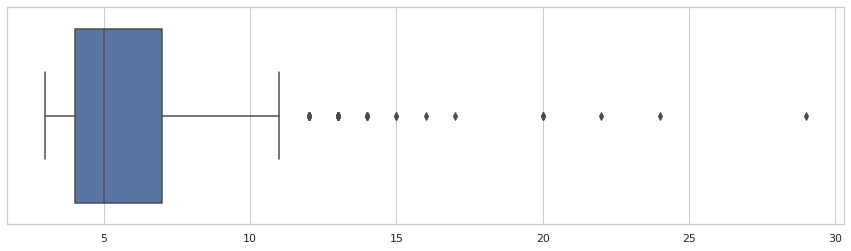

In [0]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
ax = sns.boxplot(x=summary_length_distribution ,ax=ax)

In [0]:
a = np.array(summary_length_distribution)
p = np.percentile(a, 90)
print(p)

9.0


In [0]:
a = np.array(review_length_distribution)
p = np.percentile(a, 90)
print(p)

138.10000000000014


In [0]:
review_tensor ,review_tokenizer = tokenize(reviews, max_length_review)
summary_tensor ,summary_tokenizer = tokenize(summaries, max_length_summary)

In [0]:
print(review_tensor.shape)
print(summary_tensor.shape)

(1400, 921)
(1400, 29)


Mount the google Drive and load the word2vec embedding


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My\ Drive

/content/drive/My Drive


In [0]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
vocab_size_rev,embed_matrix_rev,word2id_rev = get_embedding_matrix(review_tokenizer,model)
vocab_size_sum,embed_matrix_sum,word2id_sum = get_embedding_matrix(summary_tokenizer,model)

Train-Test Split


In [0]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(review_tensor, summary_tensor, test_size=0.2)

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = int(len(input_tensor_train)/BATCH_SIZE)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 921]), TensorShape([32, 29]))

Encoder Class


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz ,embedding_matrix):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding_dim = embedding_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim ,weights = [embedding_matrix] ,trainable = True)
    self.LSTM = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    #self.BiLSTM = tf.keras.layers.Bidirectional(self.LSTM)
    

  def call(self, x, hidden_state,cell_state):
    x = self.embedding(x)
    output, hidden_state, cell_state = self.LSTM(x, initial_state = [hidden_state ,cell_state])
    return output, hidden_state, cell_state

  def initialize_hidden_state(self):
    #print(self.LSTM.state_size)
    hidden_state = tf.zeros((self.batch_sz, self.enc_units))
    cell_state = tf.zeros((self.batch_sz, self.enc_units))
    return hidden_state , cell_state 

In [0]:
encoder = Encoder(vocab_size_rev, 300, 1024, 32 , embed_matrix_rev)
print(example_input_batch.shape)
# sample input
sample_hidden_init, sample_cell_init = encoder.initialize_hidden_state()
enc_output, sample_hidden, sample_cell = encoder(example_input_batch, sample_hidden_init ,sample_cell_init)
print ('Encoder cell state shape: (batch size, sequence length, units) {}'.format(sample_cell.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
print ('Encoder Output state shape: (batch size, sequence length, units) {}'.format(enc_output.shape))

(32, 921)
Encoder cell state shape: (batch size, sequence length, units) (32, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)
Encoder Output state shape: (batch size, sequence length, units) (32, 921, 1024)


In [0]:
encoder.summary()

Model: "encoder_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     multiple                  2371800   
_________________________________________________________________
lstm_25 (LSTM)               multiple                  5427200   
Total params: 7,799,000
Trainable params: 7,799,000
Non-trainable params: 0
_________________________________________________________________


Bahdanau Attention Class

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    self.Wc = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    #print("query_timw_axis shape/decoder hidden state {}" .format(query_with_time_axis.shape))
    #print("Initial Encoder output shape {}" .format(values.shape))
   
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    
    #print("Hidden state after NN shape {}" .format(self.W1(query_with_time_axis).shape))
    #print("Encoder output shape after NN is {}" .format(self.W2(values).shape))
    #print("Coverage vector shape afer NN is {}" .format(self.Wc(previous_step_coverage).shape))

    x = self.W1(query_with_time_axis) + self.W2(values)
    #print("Shape before tanh activation shape {}" .format(x.shape))
   
    attention_weights = tf.nn.softmax(score, axis=1)
    #print("Attention weights shape {}" .format(attention_weights.shape))
   # coverage_vector = previous_step_coverage + attention_weights
    
    #print("Coverage vector shape is {}" .format(coverage_vector.shape))

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(10)
#coverage_vector = tf.cast(tf.fill([32,max_length_review,1] ,0) , dtype=tf.float32)
#print("Initial Coverage Vector.shape {} " .format(coverage_vector.shape))
#print(coverage_vector.dtype)
context_vector,attention_weights = attention_layer(sample_hidden, enc_output)

#print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention weights shape: (batch_size, sequence_length, 1) (32, 921, 1)


Decoder Class

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,embedding_matrix):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim ,weights = [embedding_matrix] ,trainable = True)
    self.LSTM = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden_state,cell_state, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector,attention_weights = self.attention(hidden_state , enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output,hidden_state,cell_state = self.LSTM(x ,initial_state = [hidden_state ,cell_state])

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(hidden_state, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    x = tf.nn.softmax(x)

    return x, hidden_state,cell_state,attention_weights,context_vector

In [0]:
decoder = Decoder(vocab_size_sum, 300, 1024, 32,embed_matrix_sum)

sample_decoder_output, _, _,_,_ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden,sample_cell, enc_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 1508)


In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
     reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
   
  #loss_coverage = 0.1*tf.reduce_sum(tf.minimum(attention_weights, context_vector, "Smallest"))
  #loss_ = loss_ + loss_coverage
  return tf.reduce_mean(loss_)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden,enc_cell):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output,enc_hidden_state, enc_cell_state = encoder(inp, enc_hidden,enc_cell)

    dec_hidden = enc_hidden_state
    dec_cell = enc_cell_state 

    dec_input = tf.expand_dims([summary_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    coverage_vector =  tf.cast(tf.fill([32,max_length_review,1] ,0) , dtype=tf.float32)
    for t in range(1, targ.shape[1]):
     
      # passing enc_output to the decoder
      predictions, dec_hidden, dec_cell,attention_vector,context_vector = decoder(dec_input, dec_hidden, dec_cell,enc_output)
      
            
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables  
  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

Train the Model

In [0]:
EPOCHS = 50
total_loss_epoch = []
for epoch in range(EPOCHS):
  #print(epoch)
  start = time.time()
  enc_hidden,enc_cell = encoder.initialize_hidden_state()
  total_loss = 0  
  
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):    
    batch_loss = train_step(inp, targ, enc_hidden,enc_cell)
    #print("Epoch {} batch {} loss {}" .format(epoch,batch,batch_loss) )
    total_loss += batch_loss  

  total_loss_epoch.append(total_loss/steps_per_epoch)
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss/steps_per_epoch))
  #print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Loss 0.2729
Epoch 2 Loss 0.2557
Epoch 3 Loss 0.2433
Epoch 4 Loss 0.2353
Epoch 5 Loss 0.2289
Epoch 6 Loss 0.2311
Epoch 7 Loss 0.2250
Epoch 8 Loss 0.2172
Epoch 9 Loss 0.2107
Epoch 10 Loss 0.2060
Epoch 11 Loss 0.2029
Epoch 12 Loss 0.2012
Epoch 13 Loss 0.1956
Epoch 14 Loss 0.1915
Epoch 15 Loss 0.1877
Epoch 16 Loss 0.1835
Epoch 17 Loss 0.1813
Epoch 18 Loss 0.1760
Epoch 19 Loss 0.1726
Epoch 20 Loss 0.1747
Epoch 21 Loss 0.2130
Epoch 22 Loss 0.1973
Epoch 23 Loss 0.1856
Epoch 24 Loss 0.1760
Epoch 25 Loss 0.1697
Epoch 26 Loss 0.1632
Epoch 27 Loss 0.1605
Epoch 28 Loss 0.1569
Epoch 29 Loss 0.1533
Epoch 30 Loss 0.1485
Epoch 31 Loss 0.1469
Epoch 32 Loss 0.1446
Epoch 33 Loss 0.1383
Epoch 34 Loss 0.1364
Epoch 35 Loss 0.1332
Epoch 36 Loss 0.1292
Epoch 37 Loss 0.1239
Epoch 38 Loss 0.1190
Epoch 39 Loss 0.1142
Epoch 40 Loss 0.1096
Epoch 41 Loss 0.1051
Epoch 42 Loss 0.1045
Epoch 43 Loss 0.1105
Epoch 44 Loss 0.0993
Epoch 45 Loss 0.0904
Epoch 46 Loss 0.0850
Epoch 47 Loss 0.0824
Epoch 48 Loss 0.0781
E

[<tf.Tensor: shape=(), dtype=float32, numpy=0.27293777>, <tf.Tensor: shape=(), dtype=float32, numpy=0.25567347>, <tf.Tensor: shape=(), dtype=float32, numpy=0.24325663>, <tf.Tensor: shape=(), dtype=float32, numpy=0.23530707>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22891794>, <tf.Tensor: shape=(), dtype=float32, numpy=0.23114273>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2250393>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21718915>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2107033>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20599978>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20291775>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20116298>, <tf.Tensor: shape=(), dtype=float32, numpy=0.19561034>, <tf.Tensor: shape=(), dtype=float32, numpy=0.19149627>, <tf.Tensor: shape=(), dtype=float32, numpy=0.18768048>, <tf.Tensor: shape=(), dtype=float32, numpy=0.18354839>, <tf.Tensor: shape=(), dtype=float32, numpy=0.18132731>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1759

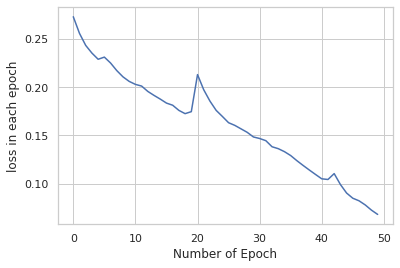

In [0]:
print(total_loss_epoch)
x_axis_epochs = [i for i in range(0,EPOCHS)]
plt.plot(x_axis_epochs, total_loss_epoch)
plt.xlabel("Number of Epoch")
plt.ylabel("loss in each epoch")
plt.show()


In [0]:
def evaluate(sentence):
  result = ''
  
  sentence = sentence.reshape(1,max_length_review)
  print(sentence.shape)
  hidden = tf.zeros((1, 300))
  print(hidden.shape)
  cell_state = tf.zeros((1, 300))
  enc_output, enc_hidden, enc_cell = encoder(sentence, hidden, cell_state)

  dec_cell = enc_cell
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([summary_tokenizer.word_index['<start>']], 0)

  print(dec_input.shape)
  coverage_vector =  tf.cast(tf.fill([32,max_length_review,1] ,0) , dtype=tf.float32)
  for t in range(max_length_summary):
    predictions, dec_hidden,dec_cell, attention_weights,context_vector = decoder(dec_input,
                                                         dec_hidden,
                                                         dec_cell,enc_output)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    #attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += summary_tokenizer.index_word[predicted_id] + ' '

    if summary_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [0]:
def get_index(index , beam_width ,vocab_size):
  #Function to get the actual index and which decoder instance it belongs to
  bins = list(range(0, (beam_width)*vocab_size, vocab_size))
  bin_index = np.digitize([index],bins)  
  if bin_index[0]!=0:
    return (index - bins[bin_index[0] - 1] , bin_index[0])
  else:
    return(index, 0)


Beam Search Implementation

In [0]:
from math import log
def evaluate(sentence):   
  result = ''
  sentence = sentence.reshape(1,max_length_review)  
  hidden = tf.zeros((1, 1024))  
  cell_state = tf.zeros((1, 1024))
  enc_output, enc_hidden, enc_cell = encoder(sentence, hidden, cell_state)
  beam_width = 3
  dec_hidden = enc_hidden
  dec_cell = enc_cell
  dec_input = tf.expand_dims([summary_tokenizer.word_index['<start>']], 0) 
  for t in range(max_length_summary):    
   
      #First time step of Beam Search:
      if t==0:        
       
        predictions, dec_hidden,dec_cell, attention_weights,context_vector = decoder(dec_input,
                                                         dec_hidden,
                                                         dec_cell,enc_output)        
       
        predicted_id = tf.argmax(predictions[0]).numpy()
        values,indices = tf.math.top_k(predictions[0], k=beam_width, sorted=True, name=None)
        dec_inputs = []
        most_likely_sentences = []        
        indices = indices.numpy()
        prob_likely_words =[]
        for i in range(1,beam_width+1):
          dec_inputs.append(tf.expand_dims([indices[i]], 0))
          most_likely_sentences.append(summary_tokenizer.index_word[indices[i]])
          prob_likely_words.append(values[i])   
        
        dec_hidden_states = [dec_hidden]*beam_width
        dec_cell_states =[dec_cell]*beam_width       
        continue
      
      dec_hidden_temp = []
      dec_cell_temp = []
      probality_list =[]
     
      for i in range(0, beam_width):     
       
        predictions, dec_hidden,dec_cell, attention_weights,context_vector = decoder(dec_inputs[i],
                                                        dec_hidden_states[i],
                                                        dec_cell_states[i],enc_output)
        dec_hidden_temp.append(dec_hidden)
        dec_cell_temp.append(dec_cell)
        predictions = list(predictions[0].numpy())
        
        #covert predictions to list
        for probability in predictions:
          if probability!= 0:           
            probality_list.append(log(probability) + prob_likely_words[i])
      
      most_likely_wordIndices = sorted(range(len(probality_list)), key=lambda i: probality_list[i],reverse=True)[:beam_width]      
      prob_likely_words = [probality_list[index] for index in most_likely_wordIndices]      
      temp_list = [get_index(index,vocab_size)for index in most_likely_wordIndices]     
      for i in range(len(temp_list)):
        word = summary_tokenizer.index_word[temp_list[i][0]]

        if word == "<end>":
          end_reached[i] = True
          return most_likely_sentence[0]         

        most_likely_sentences[i] += " " + word
        decoder_num = temp_list[i][1]

        #Assign decoder hidden state,cell state and input for the next time step corresponding the top words which are selected.
        dec_hidden_states[i] = dec_hidden_temp[decoder_num]
        dec_cell_states[i] = dec_cell_states[decoder_num]
        dec_inputs[i] = tf.expand_dims([temp_list[i][0]], 0)                                                          
      
  #return the sentence with maximum probability
  return most_likely_sentence[0]

 

In [0]:
sample_test_seq = input_tensor_train[0:50]
for index,sequence in enumerate(sample_test_seq):
  sentence = evaluate(sequence)

  print('Input: %s' % (" ".join(reviews[index])))
  print("Ground Truth Summary {} ".format(" ".join(summaries[index])))
  print('Predicted summary: {}'.format(sentence))


(1, 921)
(1, 1024)
['great', 'good', 'the'] [-0.8815391422478966, -1.6815021504583298, -2.255466279439186]
Input: <start> i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most <end>
Ground Truth Summary <start> good quality dog food <end> 
Predicted summary: great just
(1, 921)
(1, 1024)
['amazingly', 'my', 'best'] [-1.3329718602757714, -1.5810703197530203, -1.8460581621214829]
Input: <start> product arrived labeled as jumbo salted peanutsthe peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo <end>
Ground Truth Summary <start> not as advertised <end> 
Predicted summary: amazingly true to a
(1, 921)
(1, 1024)
['good', 'when', 'great'] [-2.3117601108442516, -2.354177173630463, -2.380908181042236]
Input: <